# __Step 5: Make predictions__

The best model is Word2Vec:
- Because the performance is all very similar, for interpretability purpose, choose to focus on the Word2Vec-based model with ` [min_count, window, n_gram] = [20, 8, 3]`. 
- This way there is a smaller set of eature (because min_count is high) that include tri-grams (so 3 word combinations that help with interpretation).

Goal
- Make predictions of the entire corupus


## ___Set up___

### Module import

In [22]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from pathlib import Path
import script_2_3_text_classify_w2v as script23

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting paths
work_dir   = Path.home() / "projects/plant_sci_hist/2_text_classify"

os.chdir(work_dir)

# Training data for interpretation purpose
corpus_train = work_dir / "corpus_train.json"

# The columns to focus on
target_col = 'txt'

# Trainded Word2Vec model, tokenizer, and vocab for getting embeddings
w2v_name   = work_dir / f"model_cln_w2v_20-8-3"
tok_name   = work_dir / f"model_cln_w2v_token_20-8-3"
vocab_name = work_dir / f"model_cln_w2v_vocab_20-8-3"

# Getting ngrams
ngram = 3
min_count = 20

# DNN checkpoint path
cp_filepath = work_dir / f"model_cln_w2v_20-8-3_dnn"

# Corpus to make predictions for
corpus_dir  = Path.home() / "projects/plant_sci_hist/1_obtaining_corpus"
corpus_file = corpus_dir / "pubmed_qualified.tsv"

## ___Analysis of prediction outcome___

### Load w2v model, tokenizer, and vocab

Need:
- W2V model
- Tokenizer and vocab
- Trained DNN model

In [3]:
# Load word2vec model
with open(w2v_name, "rb") as f:
  model_w2v = pickle.load(f)
model_w2v

In [4]:
# Load tokenzier and vocab
with open(tok_name, "rb") as f:
  tokenizer = pickle.load(f)

with open(vocab_name, "rb") as f:
  vocab = pickle.load(f)

### Get training/testing data

In [5]:
with corpus_train.open("r+") as f:
  corpus_combo_json = json.load(f)

## __Make predictions on the whole dataset__

### Read corpus that needs to be predicted

In [6]:
corpus_df_raw = pd.read_csv(corpus_file, delimiter='\t')

In [7]:
corpus_df_raw.shape

(1497511, 6)

In [8]:
# Drop duplicated rows
corpus_df = corpus_df_raw[corpus_df_raw.duplicated() == False]

# Rid of all records with NAs
corpus_df = corpus_df.dropna(axis=0)

# Create a new column 'txt' which is concatenated between 'Title' and 'Abstract'
corpus_df['txt'] = corpus_df['Title'] + " " + corpus_df['Abstract']
corpus_df.shape

(1385417, 7)

In [9]:
corpus_df.head(3)

,PMID,Date,Journal,Title,Abstract,QualifiedName,txt
0,36,1975-11-01,The British journal of nutrition,The effects of processing of barley-based supp...,1. In one experiment the effect on rumen pH of...,barley,The effects of processing of barley-based supp...
1,52,1975-12-02,Biochemistry,Evidence of the involvement of a 50S ribosomal...,The functional role of the Bacillus stearother...,rose,Evidence of the involvement of a 50S ribosomal...
2,60,1975-12-11,Biochimica et biophysica acta,The reaction between the superoxide anion radi...,1. The superoxide anion radical (O2-) reacts w...,tuna,The reaction between the superoxide anion radi...


In [10]:
corpus_df['txt'][0][:100]

'The effects of processing of barley-based supplements on rumen pH, rate of digestion of voluntary in'

### Get word embeddings, w2v feature matrix using corpus

In [11]:
# Get ngrams
X        = corpus_df[target_col]
X_ngrams = script23.get_ngram(X, ngram, min_count, "train", work_dir=work_dir)

    load ngrams


In [12]:
# Get embeddings
embeddings, X_w2v = script23.get_embeddings(X, model_w2v, tokenizer, vocab)

In [13]:
embeddings.shape, X_w2v.shape

((398412, 300), (1385417, 500))

In [14]:
X_w2v[0][:20]

array([    1,     1,     1,   856,     1,   631,    65,     1,     1,
       22713,   493,    43,     1,  3786,     1,  8018,  1214,     1,
        4962,  1222], dtype=int32)

### Load model

In [15]:
model = script23.get_w2v_emb_model(embeddings)
model.load_weights(cp_filepath)

2022-07-01 11:24:49.276708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-01 11:24:49.376523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-01 11:24:49.376973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-01 11:24:49.379644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate


### Make predictions 

In [16]:
y_pred_prob   = model.predict(X_w2v)
dic_y_mapping = {n:label for n,label in enumerate(np.unique([0,1]))}
y_pred        = [dic_y_mapping[np.argmax(pred)] for pred in y_pred_prob]


2022-07-01 11:30:18.988822: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2770834000 exceeds 10% of free system memory.
2022-07-01 11:31:02.193784: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-07-01 11:31:04.199553: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


In [17]:
len(y_pred)

1385417

In [18]:
corpus_df["y_prob"] = y_pred_prob[:,1]
corpus_df["y_pred"] = y_pred
corpus_df.shape

(1385417, 9)

In [21]:
corpus_df.head(5)

,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,y_prob,y_pred
0,36,1975-11-01,The British journal of nutrition,The effects of processing of barley-based supp...,1. In one experiment the effect on rumen pH of...,barley,The effects of processing of barley-based supp...,0.162140,0
1,52,1975-12-02,Biochemistry,Evidence of the involvement of a 50S ribosomal...,The functional role of the Bacillus stearother...,rose,Evidence of the involvement of a 50S ribosomal...,0.286834,0
2,60,1975-12-11,Biochimica et biophysica acta,The reaction between the superoxide anion radi...,1. The superoxide anion radical (O2-) reacts w...,tuna,The reaction between the superoxide anion radi...,0.248357,0
3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,0.716394,1
4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,0.894874,1


### Plot probability distribution

In [25]:
corpus_df['y_pred'].value_counts()

0    963677
1    421740
Name: y_pred, dtype: int64

<AxesSubplot:xlabel='y_prob', ylabel='Count'>

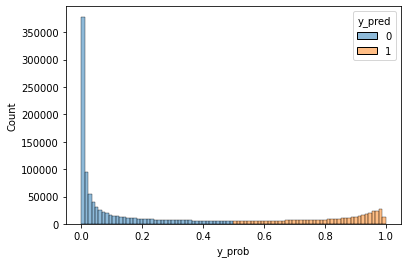

In [23]:
sns.histplot(data=corpus_df, x="y_prob", hue="y_pred")

In [ ]:
corpus_plant = work_dir / "corpus_plant_421740"
corpus_df[corpus_df["y_pred"] == 1].to_csv(corpus_plant, sep='\t')